In [1]:
import sys
import os
import json
import pickle
import torch

main_dir = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, main_dir)

from src.commands.generate_volume import generate_volume
from src import analysis
import matplotlib.pyplot as plt
import numpy as np

import umap

/net/jiang/home/li3221/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [36]:
def star2dataframe(filename, relion31=None):
    import pandas as pd
    Rvar = []  # read the variables metadata
    Rdata = []  # read the data
    start_read_line=1
    if relion31:
        count=0
        for star_line in open(filename).readlines():
            if star_line.find("data_particles") ==0:
                break
            else:
                count+=1
        start_read_line=count
    for star_line in open(filename).readlines()[start_read_line:]:
        if star_line.find("_rln") != -1:
            var = star_line.split()
            Rvar.append(var[0])
        #    Rvar_len = Rvar_len+1
        elif star_line.find("data_") != -1 or star_line.find("loop_") != -1 or len(star_line.strip()) == 0:
            continue
        else:
            Rdata.append(star_line.split())

    print(Rdata[0],Rvar)

    data = pd.DataFrame(data=Rdata,columns=Rvar)

    assert ("_rlnImageName" in data)
    tmp = data["_rlnImageName"].str.split("@", expand=True)
    indices, filenames = tmp.iloc[:, 0], tmp.iloc[:, -1]
    indices = indices.astype(int) - 1
    data["pid"] = indices
    data["filename"] = filenames
    tmp = data["filename"].str.split("/", expand=True)
    data["label"] = tmp.iloc[:, 1]

    if "_rlnClassNumber" in data:
        data.loc[:, "class"] = data["_rlnClassNumber"]
    if "_rlnHelicalTubeID" in data:
        data.loc[:, "helicaltube"] = data["_rlnHelicalTubeID"].astype(int) - 1
    if "_rlnAnglePsiPrior" in data:
        data.loc[:, "phi0"] = data["_rlnAnglePsiPrior"].astype(float).round(3) - 90.0
    return data
def create_label(dataframe):
    label_str = list(dataframe['label'])
    unique_label = list(set(label_str))
    label = []
    for i in range(len(label_str)):
        str_index = label_str[i]
        label.append(unique_label.index(str_index))
    return label

In [37]:
main_path = '/net/jiang/scratch/li3221/cryofire/10230/job537'
relative_config_path = main_path+'/empiar10230.json'
with open(relative_config_path, 'r') as f:
    config = json.load(f)

In [38]:
dataframe=star2dataframe(main_path+'/join_particles.star',relion31=True)
label = create_label(dataframe)

['1173.089706', '130.264912', '1', '90.000000', '124.167531', '0.500000', '000001@Extract/job038/DW_Micrographs/FoilHole_14817212_Data_14817538_14817539_20170415_1326-2613_cor2_DW.mrcs', 'DW_Micrographs/FoilHole_14817212_Data_14817538_14817539_20170415_1326-2613_cor2_DW.mrc', '5.628235', '0.028594', '25965.322266', '25794.960938', '-39.59074', '0.000000', '1.000000', '0.000000', '1', '112.799996', '21.106333', '89.206654', '124.167531', '2.463034', '-0.41523', '1', '0.716086', '53587.482722', '0.115407', '123'] ['_rlnCoordinateX', '_rlnCoordinateY', '_rlnHelicalTubeID', '_rlnAngleTiltPrior', '_rlnAnglePsiPrior', '_rlnAnglePsiFlipRatio', '_rlnImageName', '_rlnMicrographName', '_rlnCtfMaxResolution', '_rlnCtfFigureOfMerit', '_rlnDefocusU', '_rlnDefocusV', '_rlnDefocusAngle', '_rlnCtfBfactor', '_rlnCtfScalefactor', '_rlnPhaseShift', '_rlnOpticsGroup', '_rlnHelicalTrackLengthAngst', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginXAngst', '_rlnOriginYAngst', '_rlnClassNumber', 

In [39]:
dataframe

,_rlnCoordinateX,_rlnCoordinateY,_rlnHelicalTubeID,_rlnAngleTiltPrior,_rlnAnglePsiPrior,_rlnAnglePsiFlipRatio,_rlnImageName,_rlnMicrographName,_rlnCtfMaxResolution,_rlnCtfFigureOfMerit,...,_rlnNormCorrection,_rlnLogLikeliContribution,_rlnMaxValueProbDistribution,_rlnNrOfSignificantSamples,pid,filename,label,class,helicaltube,phi0
0,1173.089706,130.264912,1,90.000000,124.167531,0.500000,000001@Extract/job038/DW_Micrographs/FoilHole_...,DW_Micrographs/FoilHole_14817212_Data_14817538...,5.628235,0.028594,...,0.716086,53587.482722,0.115407,123,0,Extract/job038/DW_Micrographs/FoilHole_1481721...,job038,1,0,34.168
1,1180.966073,139.661280,1,90.000000,123.998007,0.500000,000002@Extract/job038/DW_Micrographs/FoilHole_...,DW_Micrographs/FoilHole_14817212_Data_14817538...,5.628235,0.028594,...,0.714618,53586.433517,0.134384,97,1,Extract/job038/DW_Micrographs/FoilHole_1481721...,job038,1,0,33.998
2,1188.842441,149.057649,1,90.000000,123.858330,0.500000,000003@Extract/job038/DW_Micrographs/FoilHole_...,DW_Micrographs/FoilHole_14817212_Data_14817538...,5.628235,0.028594,...,0.716187,53566.498951,0.061405,98,2,Extract/job038/DW_Micrographs/FoilHole_1481721...,job038,1,0,33.858
3,1196.718809,158.454018,1,90.000000,123.995668,0.500000,000004@Extract/job038/DW_Micrographs/FoilHole_...,DW_Micrographs/FoilHole_14817212_Data_14817538...,5.628235,0.028594,...,0.715443,53494.113948,0.102357,109,3,Extract/job038/DW_Micrographs/FoilHole_1481721...,job038,1,0,33.996
4,1204.595177,167.850386,1,90.000000,123.924856,0.500000,000005@Extract/job038/DW_Micrographs/FoilHole_...,DW_Micrographs/FoilHole_14817212_Data_14817538...,5.628235,0.028594,...,0.715366,53569.102342,0.082037,145,4,Extract/job038/DW_Micrographs/FoilHole_1481721...,job038,1,0,33.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261200,1715.163191,3551.216896,3,90.000000,39.602918,0.500000,000131@Extract/job029/DW_Micrographs/FoilHole_...,DW_Micrographs/FoilHole_14819468_Data_14817538...,3.269248,0.055196,...,0.715756,40263.577470,0.248470,90,130,Extract/job029/DW_Micrographs/FoilHole_1481946...,job029,1,2,-50.397
261201,1705.582573,3558.868084,3,90.000000,39.482023,0.500000,000132@Extract/job029/DW_Micrographs/FoilHole_...,DW_Micrographs/FoilHole_14819468_Data_14817538...,3.269248,0.055196,...,0.714712,40250.305690,0.181573,111,131,Extract/job029/DW_Micrographs/FoilHole_1481946...,job029,1,2,-50.518
261202,1696.001956,3566.519272,3,90.000000,39.358680,0.500000,000133@Extract/job029/DW_Micrographs/FoilHole_...,DW_Micrographs/FoilHole_14819468_Data_14817538...,3.269248,0.055196,...,0.714573,40236.780901,0.268710,66,132,Extract/job029/DW_Micrographs/FoilHole_1481946...,job029,1,2,-50.641
261203,1686.421338,3574.170459,3,90.000000,38.979335,0.500000,000134@Extract/job029/DW_Micrographs/FoilHole_...,DW_Micrographs/FoilHole_14819468_Data_14817538...,3.269248,0.055196,...,0.715386,40259.869681,0.222570,60,133,Extract/job029/DW_Micrographs/FoilHole_1481946...,job029,1,2,-51.021


In [40]:
## PCA

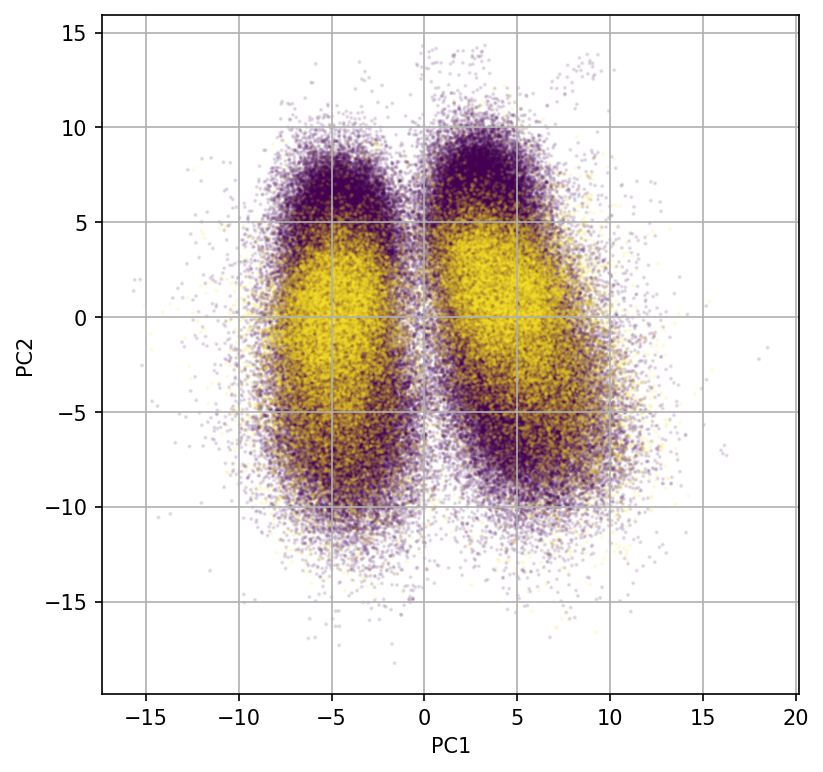

In [45]:
z_pred_pkl = main_path+'/logs/empiar10230/conf.195.pkl'

with open(z_pred_pkl, 'rb') as f:
    z_pred = pickle.load(f)
    
pc, pca = analysis.run_pca(z_pred)

plt.figure(figsize=(6, 6), dpi=150)
#label = 2833*[0]+2494*[1]
#label = [0]*3004
plt.scatter(pc[:, 0], pc[:, 1],c=label,s=1,alpha=0.1)
plt.grid(True)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [43]:
reducer = umap.UMAP(n_neighbors=100)
umap_data = reducer.fit_transform(z_pred)
print(umap_data.shape)

/net/jiang/home/li3221/anaconda3/lib/python3.7/site-packages/umap/spectral.py:341: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


(261205, 2)


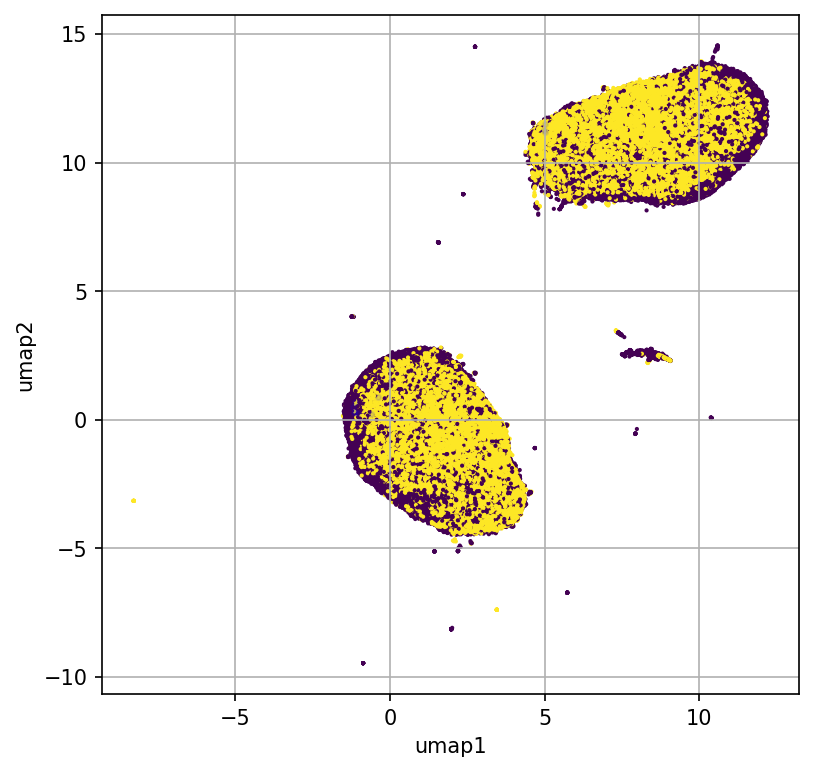

In [46]:
plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(umap_data[:, 0], umap_data[:, 1],c=label,s=1)
plt.scatter(umap_data[:10, 0], umap_data[:10, 1],c='blue',s=6,alpha=0.1)
plt.grid(True)
plt.xlabel('umap1')
plt.ylabel('umap2')
plt.show()

In [29]:
# load pose
pose_pkl = main_path+'/logs_negctf_notrans/pose.80.pkl'
with open(pose_pkl, 'rb') as f:
    pose = pickle.load(f)
print(len(pose))
angle = pose[0]
translate = pose[1]
angle_select = angle[:10]
degree = -3/180*np.pi
angle_new = np.matmul(np.array([[np.cos(degree),np.sin(degree),0],[np.sin(-degree),np.cos(degree),0],[0,0,1]]),angle[0])
print(angle[1])
#print(angle_new)

3004
[-0.0107479   0.99762512  0.0680338 ]


(3, 3) (3, 3)


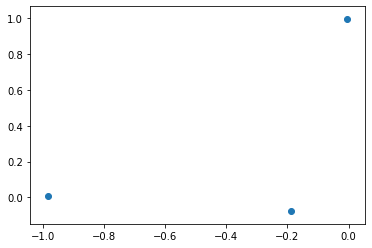

In [30]:
print(angle.shape,translate.shape)
plt.scatter(translate[:,0],translate[:,1])

In [13]:
## Generate Volumes

In [160]:
weights = main_path+'/logs_pgt2/weights.495.pkl'
n_volumes = 10
resolution = 128  # Make sure this is the resolution of the images given during training

out_dir = os.path.dirname(z_pred_pkl)
#zs = analysis.get_pc_traj(pca, config["z_dim"], n_volumes, 1, np.min(pc[..., 0]), np.max(pc[..., 0]))
zs = z_pred[-10:-1]
z_pkl = os.path.join(os.path.dirname(z_pred_pkl), 'z_traversal.pkl')

with open(z_pkl, 'wb') as f:
    pickle.dump(zs, f)

generate_volume(config, weights, resolution, out_dir, z_pkl)

2023-09-08 11:56:39.147995     Will use gt poses
2023-09-08 11:56:39.207197     Generating volume 0...
2023-09-08 11:56:39.859661     Generating volume 1...
2023-09-08 11:56:40.582816     Generating volume 2...
2023-09-08 11:56:41.186302     Generating volume 3...
2023-09-08 11:56:41.829354     Generating volume 4...
2023-09-08 11:56:42.510311     Generating volume 5...
2023-09-08 11:56:43.373955     Generating volume 6...
2023-09-08 11:56:44.047046     Generating volume 7...
2023-09-08 11:56:45.336672     Generating volume 8...
2023-09-08 11:56:45.910965     Done


In [ ]:
def normalize_vector( v, return_mag =False):
    batch=v.shape[0]
    v_mag = torch.sqrt(v.pow(2).sum(1))# batch
    v_mag = v_mag.view(batch,1).expand(batch,v.shape[1])
    v = v/v_mag
    if(return_mag==True):
        return v, v_mag[:,0]
    else:
        return v
pose_axis_pkl = main_path+'/logs_test4/pose_axis.495.pkl'
pose_rot_axis_pkl = main_path+'/logs_test4/pose_rot_axis.495.pkl'
with open(pose_axis_pkl, 'rb') as f:
    pose_axis = pickle.load(f)
with open(pose_rot_axis_pkl, 'rb') as f:
    pose_rot_axis = pickle.load(f)
pose_axis_norm = normalize_vector(torch.tensor(pose_axis))
pose_rot_axis_norm = normalize_vector(torch.tensor(pose_rot_axis))

plt.figure(figsize=(6, 6), dpi=150)
plt.scatter(pose_rot_axis_norm[:,0],pose_rot_axis_norm[:,1],s=1)
for i in range(10):
    plt.text(pose_rot_axis_norm[i,0],pose_rot_axis_norm[i,1],i,fontsize=5)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.hlines(y=0, xmin=-1, xmax=1)
plt.vlines(x=0, ymin=-1, ymax=1)
print(pose_axis_norm[0],pose_axis_norm[10])
print(pose_rot_axis_norm[0],pose_rot_axis_norm[10])